In [1]:
%env CUDA_VISIBLE_DEVICES=-1
import torch
import numpy as np
import pickle
import pylab as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import sys
sys.path.append('/home/airplaneless/source/Skoltech/CIG/k-space-mri/')

import pytorch_lightning as pl
from dataset import BraTS2dDataset
from models import BraTSClassifierBinary, BraTSClassifierHuber
from igs import train_sampling_pattern_1d, test_sampling_pattern, EquispacedMaskFunc
# plt.style.use('bmh')
from matplotlib.colors import LinearSegmentedColormap


plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'grid.color': 'k',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'patch.edgecolor': 'white',
    'axes.edgecolor': 'white',
    'savefig.edgecolor': 'white',
    'savefig.facecolor': 'white',
})

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))

In [3]:
z_img = np.load('unnamed_inputs.npy')
igs_img = np.load('igs_inputs.npy')
full_img = np.load('full_inputs.npy')
z_attrs = np.load('unnamed_attrs.npy')
igs_attrs = np.load('igs_attrs.npy')
full_attrs = np.load('full_attrs.npy')

z_logit = torch.tensor([[0.4163, 0.1496]])
igs_logit = torch.tensor([[-0.7218,  1.1933]])
full_logit = torch.tensor([[-1.5318,  1.9326]])

In [4]:
z_logit.softmax(1), igs_logit.softmax(1), full_logit.softmax(1)

(tensor([[0.5663, 0.4337]]),
 tensor([[0.1284, 0.8716]]),
 tensor([[0.0303, 0.9697]]))

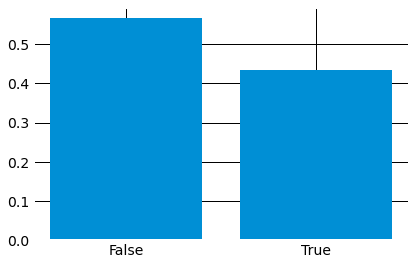

In [5]:
plt.bar(x=['False','True'], height=z_logit.softmax(1)[0])
plt.show()

In [6]:
def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

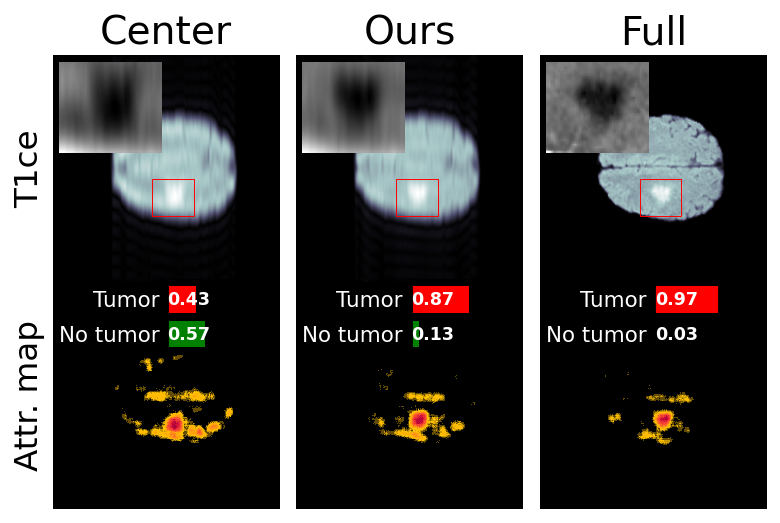

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

default_cmap = LinearSegmentedColormap.from_list('binary_r', 
                                                 [(0, '#000000'),
                                                  (0.01, '#FFC300'),
                                                  (0.1, '#FF5733'),
                                                  (0.5, '#C70039'),
                                                  (1, '#900C3F')], N=256)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(6, 4), dpi=140,
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                       gridspec_kw=dict(wspace=0.0, hspace=0.0))
ax[0,0].imshow(z_img[0,3], cmap=plt.cm.bone)
at1 = ax[1,0].imshow(z_attrs[0,3], cmap=default_cmap)
ax[0,0].set_title('Center')
ax[0,1].imshow(igs_img[0,3], cmap=plt.cm.bone)
at2 = ax[1,1].imshow(igs_attrs[0,3], cmap=default_cmap)
ax[0,1].set_title('Ours')
ax[0,2].imshow(full_img[0,3], cmap=plt.cm.bone)
at3 = ax[1,2].imshow(full_attrs[0,3], cmap=default_cmap)
ax[0,2].set_title('Full')

# fig = plt.figure(figsize=(6, 4), dpi=140, frameon=False)
# plt.subplot(3, 3, 1, frameon=False, xticks=[], yticks=[])
# plt.axis('off')
# plt.imshow(z_img[0, 3], cmap=plt.cm.bone)
# plt.subplot(3, 3, 2, frameon=False, xticks=[], yticks=[])
# plt.axis('off')
# plt.imshow(igs_img[0, 3], cmap=plt.cm.bone)
# plt.subplot(3, 3, 3, frameon=False, xticks=[], yticks=[])
# plt.axis('off')
# plt.imshow(full_img[0, 3], cmap=plt.cm.bone)
# plt.subplot(3, 3, 4, frameon=False, xticks=[], yticks=[])
# plt.axis('off')
# at1 = plt.imshow(z_attrs[0, 3], cmap=default_cmap)
# plt.subplot(3, 3, 5, frameon=False, xticks=[], yticks=[])
# plt.axis('off')
# at2 = plt.imshow(igs_attrs[0, 3], cmap=default_cmap)
# plt.subplot(3, 3, 6, frameon=False, xticks=[], yticks=[])
# plt.axis('off')
# at3 = plt.imshow(full_attrs[0, 3], cmap=default_cmap)

# ax1 = plt.subplot(3, 3, 7, frameon=False, xticks=[], yticks=[], aspect=0.1)
# plt.colorbar(at1, cax=ax1, orientation='horizontal')
# ax2 = plt.subplot(3, 3, 8, frameon=False, xticks=[], yticks=[], aspect=0.1)
# plt.colorbar(at2, cax=ax2, orientation='horizontal')
# ax3 = plt.subplot(3, 3, 9, frameon=False, xticks=[], yticks=[], aspect=0.1)
# plt.colorbar(at3, cax=ax3, orientation='horizontal')

# plt.subplots_adjust(wspace=0.0, hspace=0.0)
# plt.show()

# divider = make_axes_locatable(ax[1,0])
# cax = divider.append_axes("bottom", size="15%", pad=0.0)
# fig.colorbar(at1, cax=cax, orientation="horizontal")

# cax = fig.add_axes([0.0, 0.0, 0.5, 0.1])
# fig.colorbar(at1, cax=cax, orientation='horizontal')

for i, logit in enumerate([z_logit, igs_logit, full_logit]):
    ax1 = add_subplot_axes(ax[1,i], [0.5,0.7,0.3,0.3])
#     ax1.set_title('class\nscores', fontdict=dict(color='white', size=10), loc='left', y=0, pad=10, x=-1.5)
    ax1.barh(y=['No tumor','Tumor'], width=logit.softmax(1)[0], edgecolor='k', color=['g', 'r'])
    ax1.tick_params(colors='w')
    ax1.spines['bottom'].set_color('k')
    ax1.spines['top'].set_color('k')
    ax1.spines['left'].set_color('k')
    ax1.spines['right'].set_color('k')
    ax1.set_xlim(0.0, 1.0)
    ax1.get_xaxis().set_visible(False)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(11) 
    for I, v in enumerate(logit.softmax(1)[0]):
        v = v.item()
        ax1.text(0.02, I - 0.18, "%.2f" % v, color='white', fontweight='bold', size=9)
    ax1.set_facecolor('black')

for i in range(3):
    im = plt.matplotlib.offsetbox.OffsetImage(ax[0,i].images[0].get_array().data[130:130+39,105:105+44], zoom=1.2, cmap=plt.cm.binary)
    rect = plt.matplotlib.patches.Rectangle((105, 130), 44, 39, linewidth=0.5, edgecolor='r', facecolor='none')
    im.image.axes = ax[0,i]
    ab = plt.matplotlib.offsetbox.AnnotationBbox(
        im, (0, 0),
        xybox=(60., 55.),
        pad=0.2,
        frameon=False,
    )
    ax[0,i].add_artist(ab)
    ax[0,i].add_patch(rect)
    
ax[0,0].set_ylabel('T1ce')
ax[1,0].set_ylabel('Attr. map')
plt.savefig('brats-clf-ex1.eps', bbox_inches = "tight")

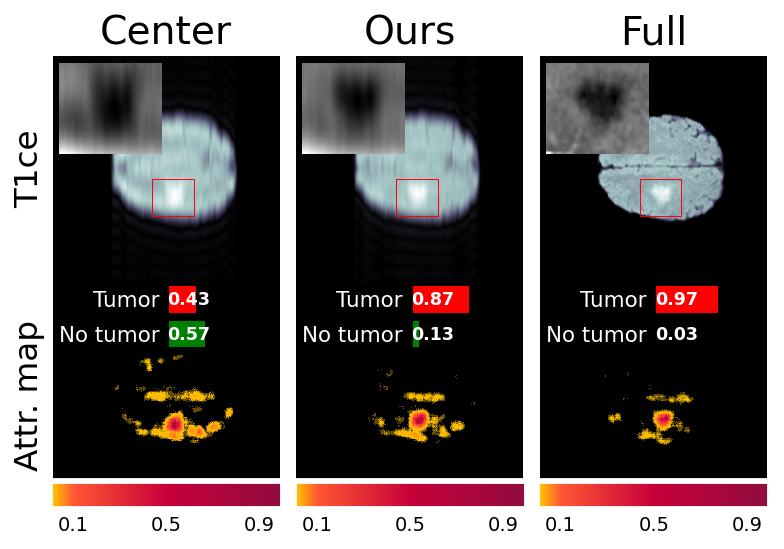

In [131]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

default_cmap = LinearSegmentedColormap.from_list('binary_r', 
                                                 [(0, '#000000'),
                                                  (0.01, '#FFC300'),
                                                  (0.1, '#FF5733'),
                                                  (0.5, '#C70039'),
                                                  (1, '#900C3F')], N=256)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(6, 4), dpi=140,
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                       gridspec_kw=dict(wspace=0.0, hspace=0.0))
ax[0,0].imshow(z_img[0,3], cmap=plt.cm.bone)
at1 = ax[1,0].imshow(z_attrs[0,3], cmap=default_cmap)
ax[0,0].set_title('Center')
ax[0,1].imshow(igs_img[0,3], cmap=plt.cm.bone)
at2 = ax[1,1].imshow(igs_attrs[0,3], cmap=default_cmap)
ax[0,1].set_title('Ours')
ax[0,2].imshow(full_img[0,3], cmap=plt.cm.bone)
at3 = ax[1,2].imshow(full_attrs[0,3], cmap=default_cmap)
ax[0,2].set_title('Full')

for i, logit in enumerate([z_logit, igs_logit, full_logit]):
    ax1 = add_subplot_axes(ax[1,i], [0.5,0.7,0.3,0.3])
#     ax1.set_title('class\nscores', fontdict=dict(color='white', size=10), loc='left', y=0, pad=10, x=-1.5)
    ax1.barh(y=['No tumor','Tumor'], width=logit.softmax(1)[0], edgecolor='k', color=['g', 'r'])
    ax1.tick_params(colors='w')
    ax1.spines['bottom'].set_color('k')
    ax1.spines['top'].set_color('k')
    ax1.spines['left'].set_color('k')
    ax1.spines['right'].set_color('k')
    ax1.set_xlim(0.0, 1.0)
    ax1.get_xaxis().set_visible(False)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(11) 
    for I, v in enumerate(logit.softmax(1)[0]):
        v = v.item()
        ax1.text(0.02, I - 0.18, "%.2f" % v, color='white', fontweight='bold', size=9)
    ax1.set_facecolor('black')

for i in range(3):
    im = plt.matplotlib.offsetbox.OffsetImage(ax[0,i].images[0].get_array().data[130:130+39,105:105+44], zoom=1.2, cmap=plt.cm.binary)
    rect = plt.matplotlib.patches.Rectangle((105, 130), 44, 39, linewidth=0.5, edgecolor='r', facecolor='none')
    im.image.axes = ax[0,i]
    ab = plt.matplotlib.offsetbox.AnnotationBbox(
        im, (0, 0),
        xybox=(60., 55.),
        pad=0.2,
        frameon=False,
    )
    ax[0,i].add_artist(ab)
    ax[0,i].add_patch(rect)
    
ax[0,0].set_ylabel('T1ce')
ax[1,0].set_ylabel('Attr. map')

for i in range(3):
    cax = fig.add_axes([0.087 + 0.29 * i, 0.07, 0.277, 0.05])
    cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.matplotlib.colors.Normalize(0.0, 1.0), cmap=default_cmap), 
                      cax=cax, orientation='horizontal')
    cb.set_ticks([0.1, 0.5, 0.9])
    cax.tick_params(labelsize=10) 

plt.savefig('brats-clf-ex1.eps', bbox_inches = "tight")